## Contours in OpenCV

Install OpenCV via pip. Note that we need opencv-contrib-python for some of the future exercises (though it's enough to install just `opencv-python` for this one).

In [1]:
#!pip install opencv-contrib-python

Tasks: 
0. Load contours_exercise.jpg
1. Estimate edges
2. Count the number of items (= the number of external contours)
3. Count the number of green items
4. Count the number of rectangular items (including square ones)
5. Count the total number of holes

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


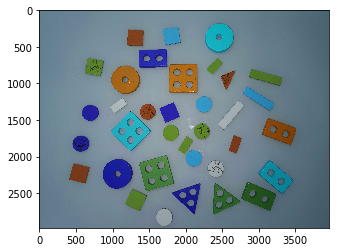

In [2]:
img = cv2.imread("./contours_exercise.jpg")
plt.imshow(img)

#### Oops, defult colors in opencv are BGR


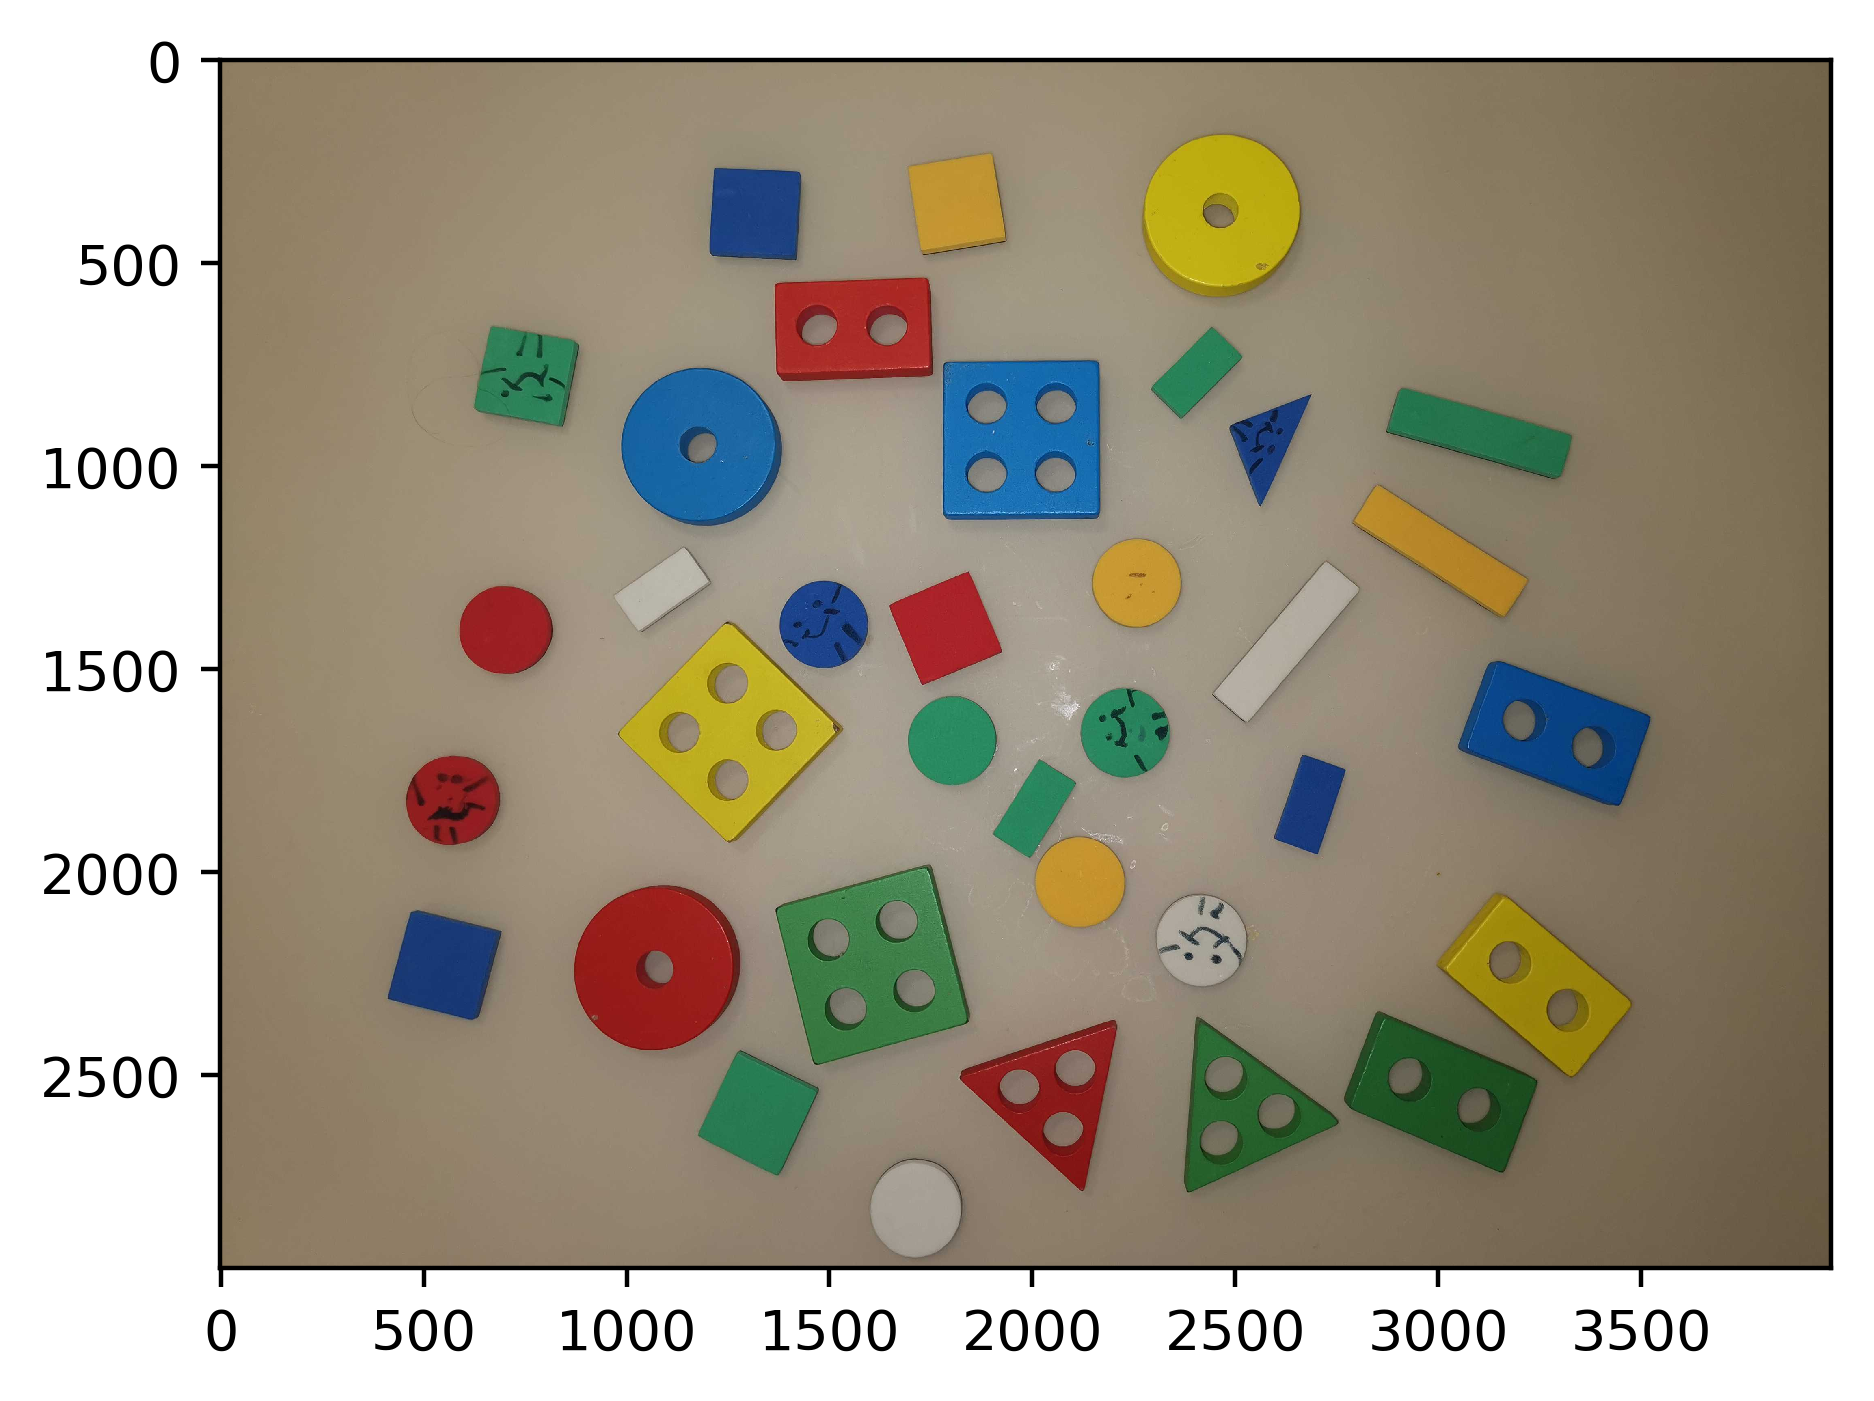

In [34]:
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = img[..., ::-1] #it' the same

plt.figure(dpi=400)
plt.imshow(img)

### Convert colors to HLS space

In [4]:
HLS = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)


In [35]:
HUE

array([[19, 19, 19, ..., 20, 20, 20],
       [19, 19, 19, ..., 20, 20, 20],
       [19, 19, 19, ..., 20, 20, 20],
       ...,
       [19, 19, 19, ..., 17, 17, 17],
       [19, 19, 19, ..., 17, 17, 17],
       [19, 19, 19, ..., 17, 17, 17]], dtype=uint8)

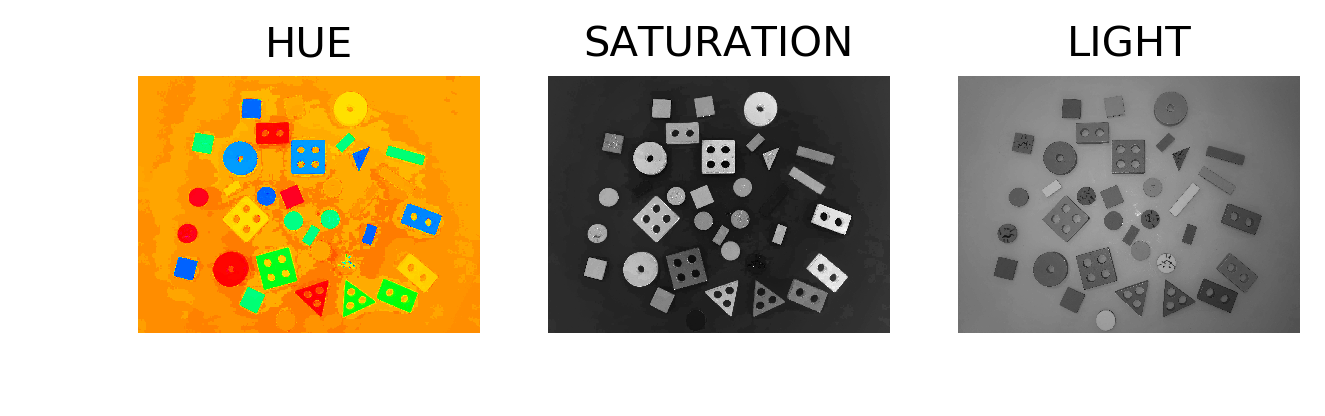

In [5]:
HUE = HLS[:, :, 0]              # Split attributes
LIGHT = HLS[:, :, 1]
SAT = HLS[:, :, 2]

plt.figure(dpi=250)
plt.subplot(1,3,1)              # Plot color attributes
plt.imshow(HUE, cmap='hsv')
plt.title('HUE')
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(SAT, cmap='gray')
plt.title('SATURATION')
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(LIGHT, cmap='gray')
plt.title('LIGHT')
plt.axis('off')
plt.show()

### Separate objects from background

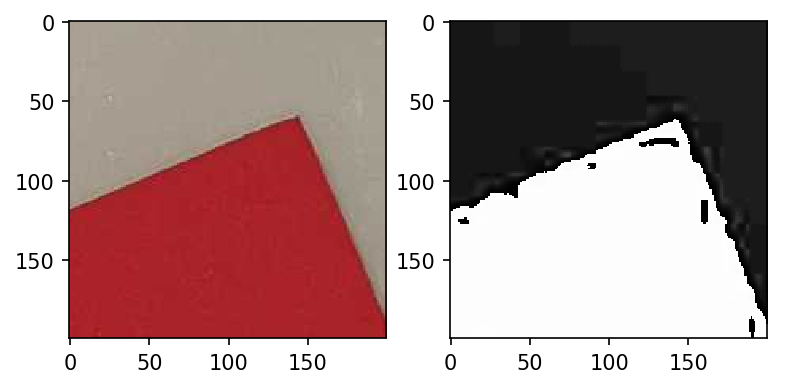

In [48]:
plt.figure(dpi=150)
plt.subplot(1,2,1)   
plt.imshow(img2[1200:1400, 1700:1900])
plt.subplot(1,2,2)     
plt.imshow(HUE[1200:1400, 1700:1900], cmap="gray")

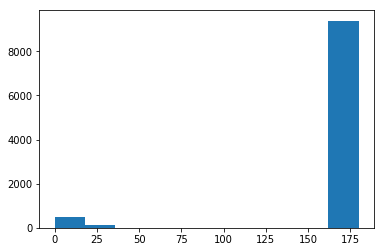

In [52]:
plt.hist(HUE[1300:1400, 1700:1800].flatten());

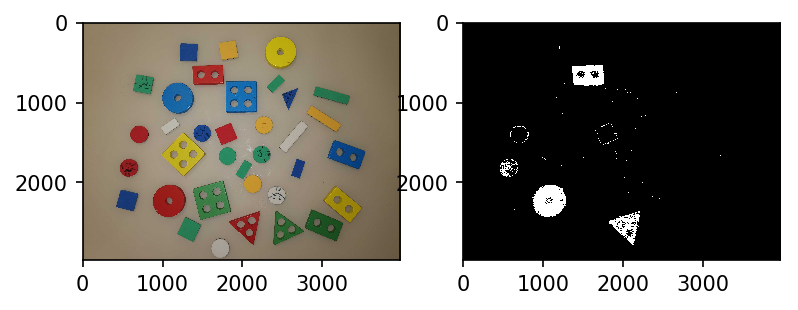

In [54]:
mask = (HUE < 10) | (HUE > 180)
img2 = img.copy()
# img2[mask] = 0

plt.figure(dpi=150)
plt.subplot(1,2,1)   
# plt.axis('off')
plt.imshow(img2)
plt.subplot(1,2,2)     
# plt.axis('off')
plt.imshow(mask, cmap="gray")

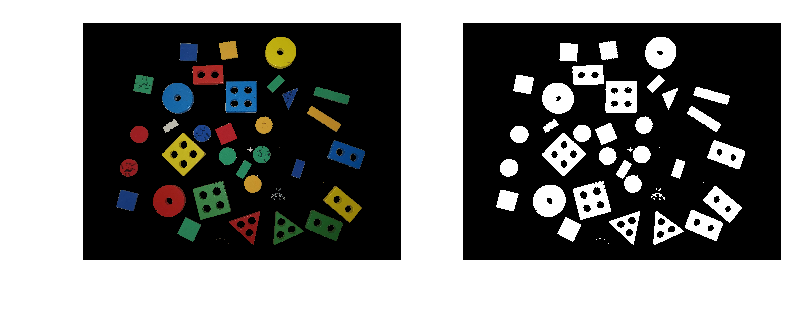

In [59]:
background = np.median(HLS, axis=(0,1))
#if background was red - we need to mask it out more carefully
mask = np.mean(np.abs(HLS-background), axis=-1) < 25
img2 = img.copy()
img2[mask] = 0

plt.figure(dpi=150)
plt.subplot(1,2,1)   
plt.axis('off')
plt.imshow(img2)
plt.subplot(1,2,2)  
plt.axis('off')
# plt.imshow(img)
plt.imshow(1 - mask, cmap="gray")

A bit of refinemnet with morphology

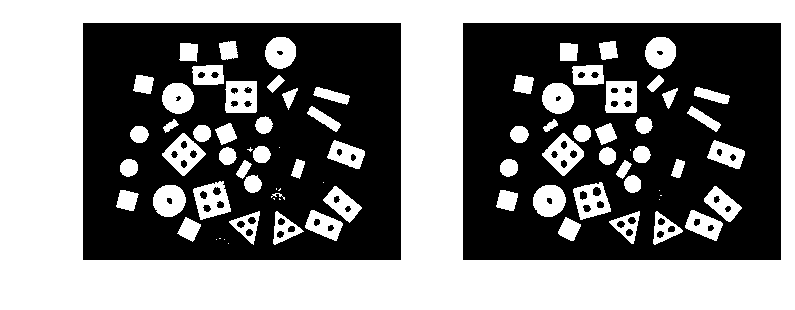

In [60]:
mask_int = mask.astype(np.uint8)
kernel = np.ones((17,17))
mask_int = cv2.morphologyEx(mask_int, cv2.MORPH_CLOSE, kernel)
kernel = np.ones((15,15))
mask_int = cv2.morphologyEx(mask_int, cv2.MORPH_OPEN, kernel)
img2 = img.copy()
img2[mask_int == 1] = 0


plt.figure(dpi=150)
plt.subplot(1,2,1)   
plt.axis('off')
plt.imshow(1 - mask, cmap="gray")
plt.subplot(1,2,2)  
plt.axis('off')
plt.imshow(1 - mask_int, cmap="gray")

We can't reliably detect white objects with color segmentation.

As you can see, if we move white circle in the center of the image - it's indistinguishable 

So it's better to focus on the objects we can detect consitently

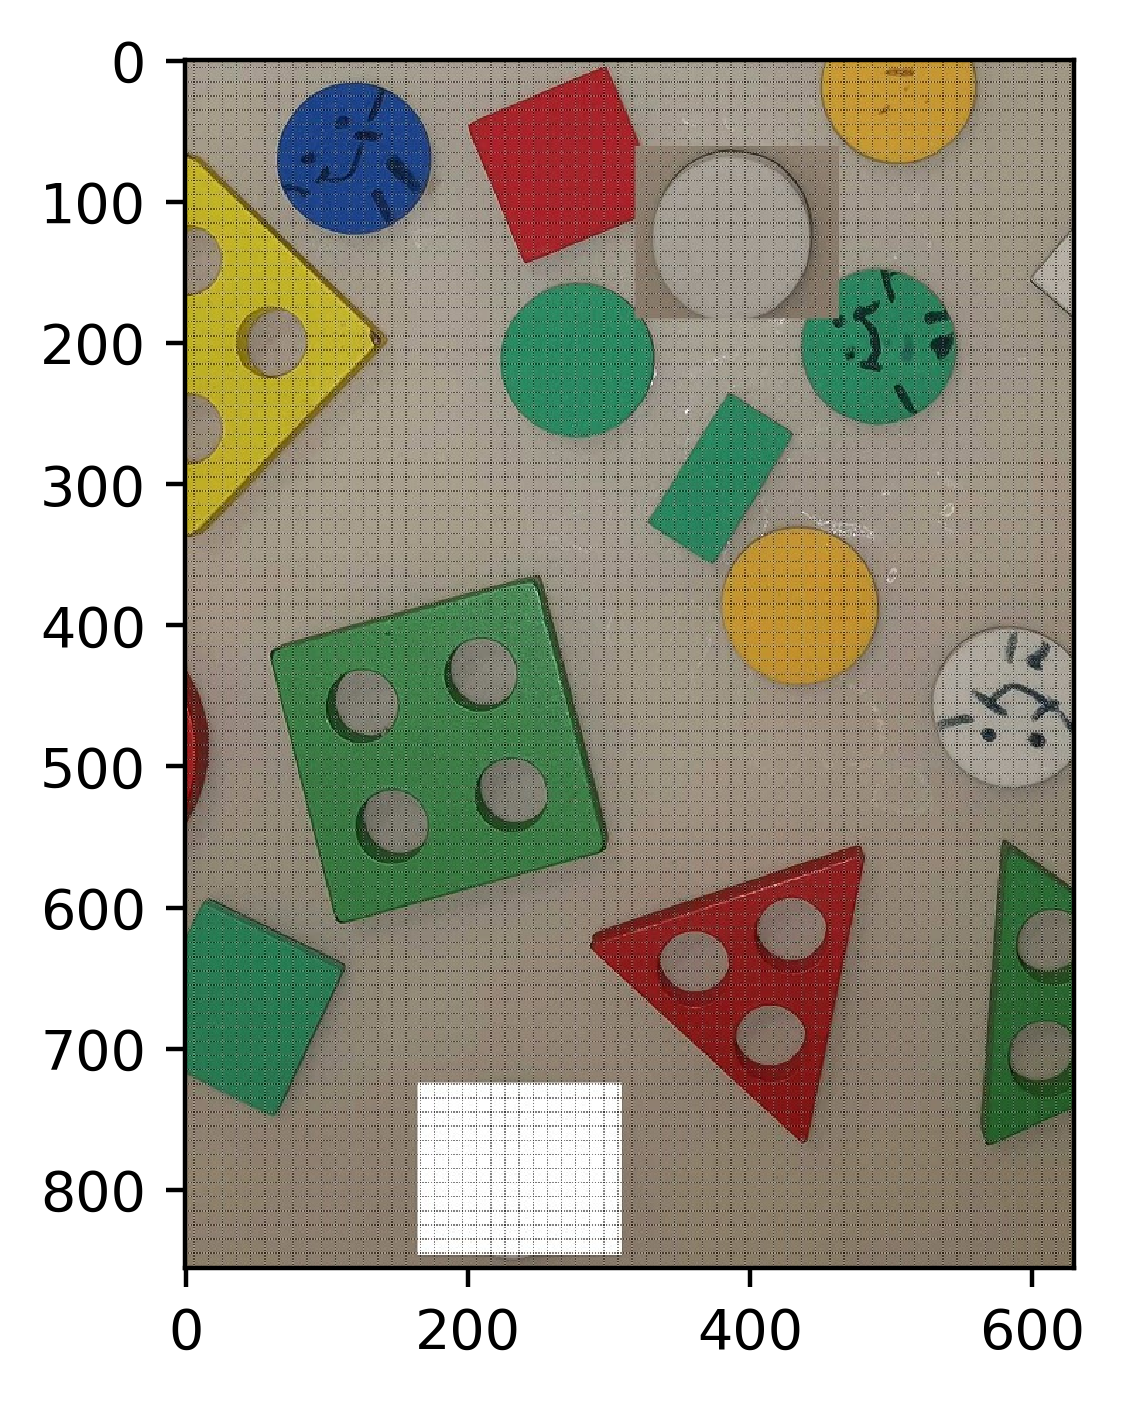

In [11]:
i_ex= cv2.imread("moved.jpg")[...,::-1]
plt.figure(dpi=400)
plt.imshow(i_ex)

### Drawing all the contours

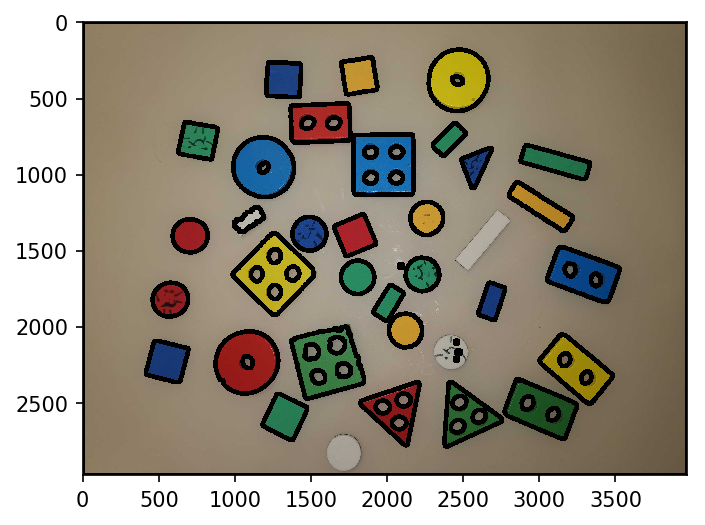

In [22]:
contours, hierarchy = cv2.findContours(mask_int, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

img_cnt = img.copy()
cv2.drawContours(img_cnt, contours, -1, (0,0,0), 30)
plt.figure(dpi=150)
plt.imshow(img_cnt)

OpenCV represents hierarchy as an array of four values : [Next, Previous, First_Child, Parent]

In [23]:
hierarchy[0][:10]

array([[-1, -1,  1, -1],
       [ 2, -1, -1,  0],
       [ 6,  1,  3,  0],
       [ 4, -1, -1,  2],
       [ 5,  3, -1,  2],
       [-1,  4, -1,  2],
       [10,  2,  7,  0],
       [ 8, -1, -1,  6],
       [ 9,  7, -1,  6],
       [-1,  8, -1,  6]], dtype=int32)

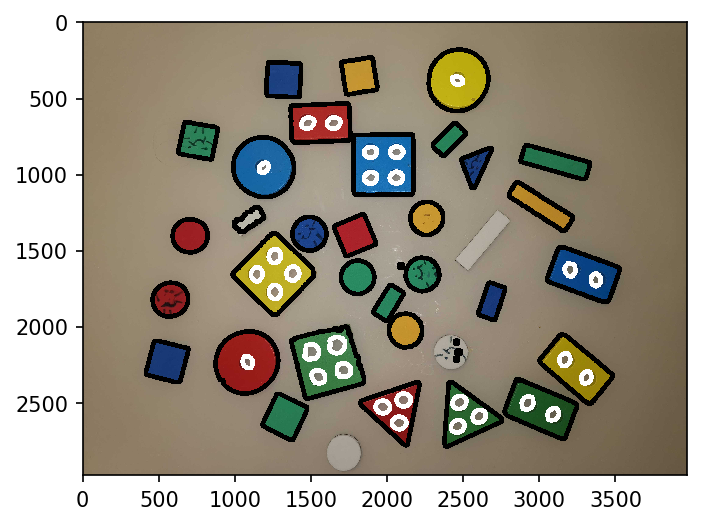

In [25]:
img_cnt = img.copy()
for i in range(len(contours)):
    if hierarchy[0][i][-1] < 0:
        continue #outermost contour
    elif hierarchy[0][i][-1] == 0:
        #main objects
        color = (0,0,0)
    elif hierarchy[0][i][-1] > 0:
        #inner holes
        color = (255,255,255)
    cv2.drawContours(img_cnt, contours, i, color, 30)
    
    
plt.figure(dpi=150)
plt.imshow(img_cnt)

### Exploring countour features

Select one contour to play with (the largest one for example)

In [26]:
#we can compute area of each contour 
areas = (cv2.contourArea(cnt) for  cnt in contours)
#then exclude the first one = the whole image
areas = filter(lambda x: x[0] != 0, enumerate(areas))
#and select the largest one
cnt_id, area = max(areas, key=lambda x: x[1])
cnt_id, area

(37, 157100.5)

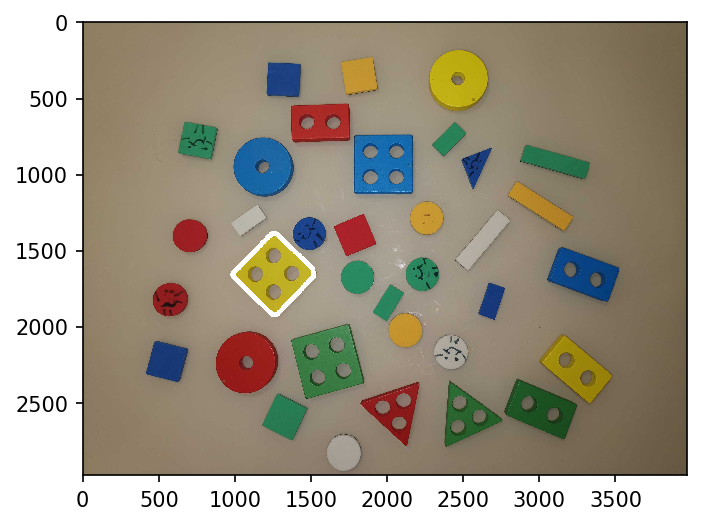

In [27]:
img_1_cnt = img.copy()
cv2.drawContours(img_1_cnt, contours, cnt_id, color, 30)

plt.figure(dpi=150)
plt.imshow(img_1_cnt)

#### We can easily compute image moments https://en.wikipedia.org/wiki/Image_moment


In [28]:
M = cv2.moments(contours[cnt_id])
#m00 == area
M

{'m00': 157100.5,
 'm01': 260041262.66666666,
 'm02': 432487388207.9166,
 'm03': 722674621254021.5,
 'm10': 197238530.16666666,
 'm11': 326450908056.875,
 'm12': 542890720842737.9,
 'm20': 249668342860.75,
 'm21': 413190804661726.25,
 'm30': 318566794309419.0,
 'mu02': 2052995642.1748047,
 'mu03': 1595547062.75,
 'mu11': -28997678.991027832,
 'mu12': 1961229422.987793,
 'mu20': 2036809018.992218,
 'mu21': -956066207.7441406,
 'mu30': -4384071771.25,
 'nu02': 0.08318267703638013,
 'nu03': 0.00016310440888946332,
 'nu11': -0.0011749194770623442,
 'nu12': 0.0002004861988725736,
 'nu20': 0.08252683217200411,
 'nu21': -9.773363463471355e-05,
 'nu30': -0.0004481606663148324}

#### For example to get center of mass

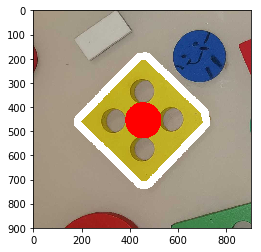

In [61]:
cx = int(M['m10']/M['m00'])
cy = int(M['m01']/M['m00'])
img_c = img_1_cnt.copy()
cv2.circle(img_c, (cx, cy), 75, (255,0,0), -1)
plt.imshow(img_c[1200:2100, 800:1700])

#### Or get bounding rect (black) and bounding rect of min area (red)

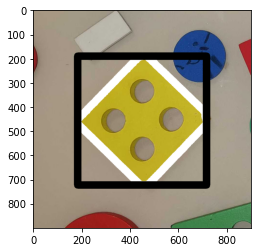

In [34]:
img_r = img_1_cnt.copy()
x,y,w,h = cv2.boundingRect(contours[cnt_id])
cv2.rectangle(img_r,(x,y),(x+w,y+h),(0,0,0),30)
plt.imshow(img_r[1200:2100, 800:1700])

In [74]:
rect

((1255.86474609375, 1654.880859375),
 (403.3543701171875, 397.77386474609375),
 -46.08914566040039)

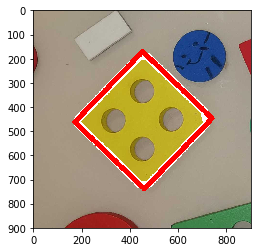

In [73]:
img_r = img_1_cnt.copy()
rect = cv2.minAreaRect(contours[cnt_id])
box = cv2.boxPoints(rect)
box = np.int0(box)
cv2.drawContours(img_r,[box],0,(255,0,0),20)
plt.imshow(img_r[1200:2100, 800:1700])

### Others are the same, you may try it by yourself
examples are https://docs.opencv.org/master/dd/d49/tutorial_py_contour_features.html

other mehods:
- Convex Hull
- Minimum Enclosing Circle
- Fitting an Ellipse
- Fitting a Line

### Approximating contour

Usually contour consist of many points

In [19]:
contours[cnt_id], contours[cnt_id].shape

(array([[[1254, 1391]],
 
        [[1255, 1390]],
 
        [[1271, 1390]],
 
        ...,
 
        [[1236, 1396]],
 
        [[1236, 1393]],
 
        [[1238, 1391]]], dtype=int32),
 (603, 1, 2))

##### 605 points for this simple rect! Let's reduce it

In [63]:
#Second argument specify whether shape is a closed contour (if passed True)
perimeter = cv2.arcLength(contours[cnt_id], True) 
perimeter

1645.4124641418457

In [66]:
epsilon = 0.01 * perimeter
approx = cv2.approxPolyDP(contours[cnt_id],epsilon,True)
approx

array([[[1255, 1390]],

       [[1500, 1610]],

       [[1515, 1653]],

       [[1273, 1921]],

       [[1242, 1921]],

       [[ 984, 1669]]], dtype=int32)

Just 4 points for the rect, great!

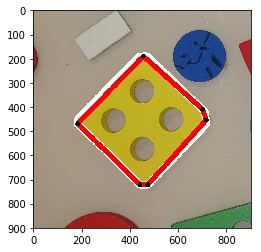

In [67]:
img_r = img_1_cnt.copy()
cv2.drawContours(img_r, [approx], 0, (255,0,0), 20)
cv2.drawContours(img_r, approx, -1, (0,0,0), 20)

plt.imshow(img_r[1200:2100, 800:1700])

### We may classify objects based on the number of points in the approximation

In [75]:
def get_shpae(approx):
    if len(approx) == 3:
        shape = "triangle"
    elif len(approx) == 4:
#         (x, y, w, h) = cv2.boundingRect(approx)
        
        area = cv2.contourArea(approx)
        perimeter = cv2.arcLength(approx, True) 
        ar = area * 16 / perimeter**2
        shape = "square" if ar >= 0.95 and ar <= 1.05 else "rectangle"
    else:
        shape = "circle"
    return shape
get_shpae(approx)

'circle'

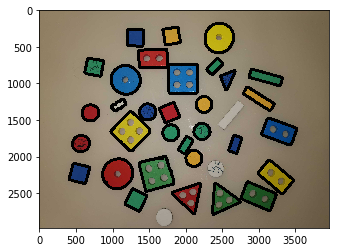

In [77]:
img_cnt = img.copy()
#drawing contours first makes text more visible
for i in range(len(contours)):
    if hierarchy[0][i][-1] != 0:
        continue
    if cv2.contourArea(contours[i]) < 1000:
        continue
    cv2.drawContours(img_cnt, contours, i, (0,0,0), 40)
plt.imshow(img_cnt)

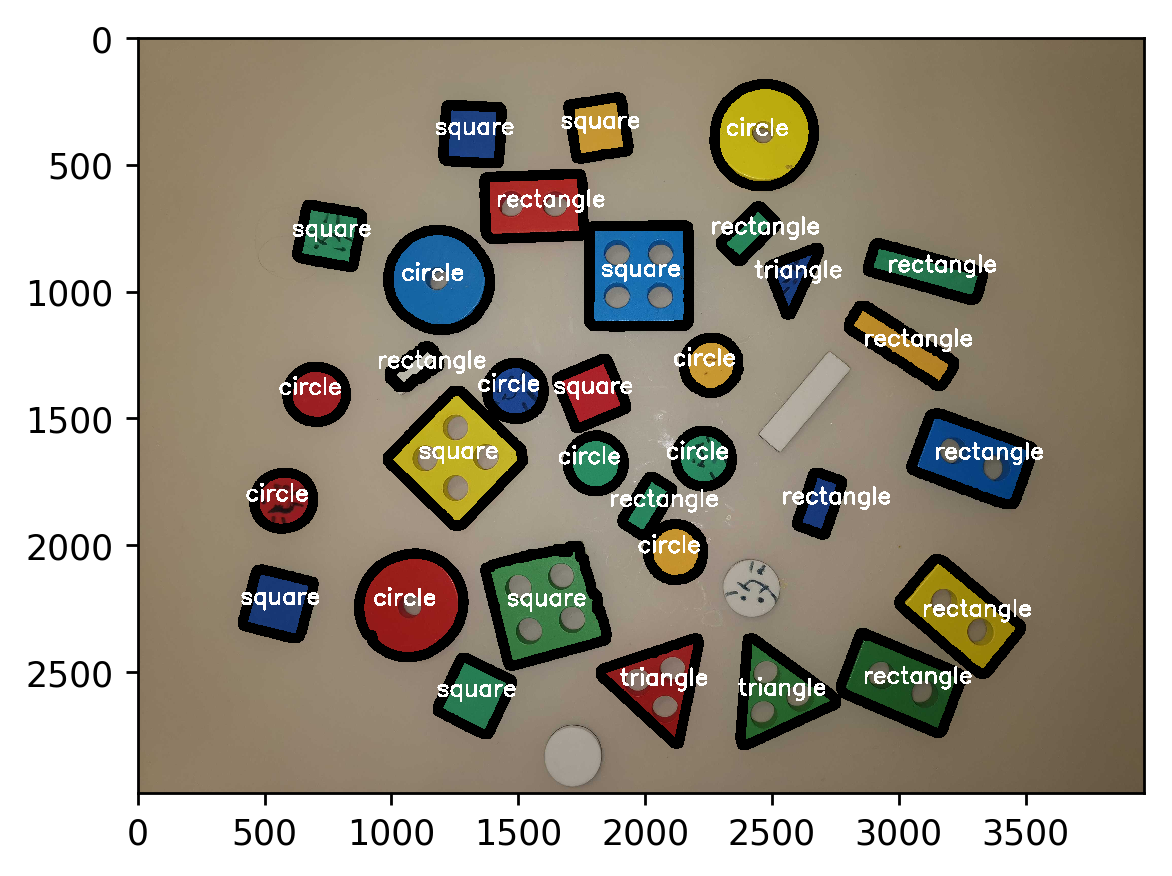

In [78]:
for i in range(len(contours)):
    if hierarchy[0][i][-1] != 0:
        continue
    if cv2.contourArea(contours[i]) < 1000:
        continue
    perimeter = cv2.arcLength(contours[i], True)
    approx = cv2.approxPolyDP(contours[i], 0.04 * perimeter, True)
    shape = get_shpae(approx)
    M = cv2.moments(contours[i])
    cX = int((M["m10"] / M["m00"]))
    cY = int((M["m01"] / M["m00"]))
    if M["m00"] < 100:
        continue
    cv2.putText(img_cnt, shape, (cX-150, cY), cv2.FONT_HERSHEY_SIMPLEX,
        3, (255, 255, 255), 10)
    
plt.figure(dpi=250)    
plt.imshow(img_cnt)

### Finally let's count the number of holes

In [26]:
n_holes = np.zeros(len(hierarchy[0]), dtype=np.int32)
for i, h in enumerate(hierarchy[0]):
    parent = h[-1]
    n_holes[parent] += 1
n_holes

array([36,  0,  3,  0,  0,  0,  3,  0,  0,  0,  2,  0,  0,  0,  0,  0,  0,
        2,  0,  0,  1,  0,  4,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        2,  0,  0,  4,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,
        0,  4,  0,  0,  0,  0,  0,  0,  2,  0,  0,  0,  0,  1,  1])

(-0.5, 3967.5, 2975.5, -0.5)

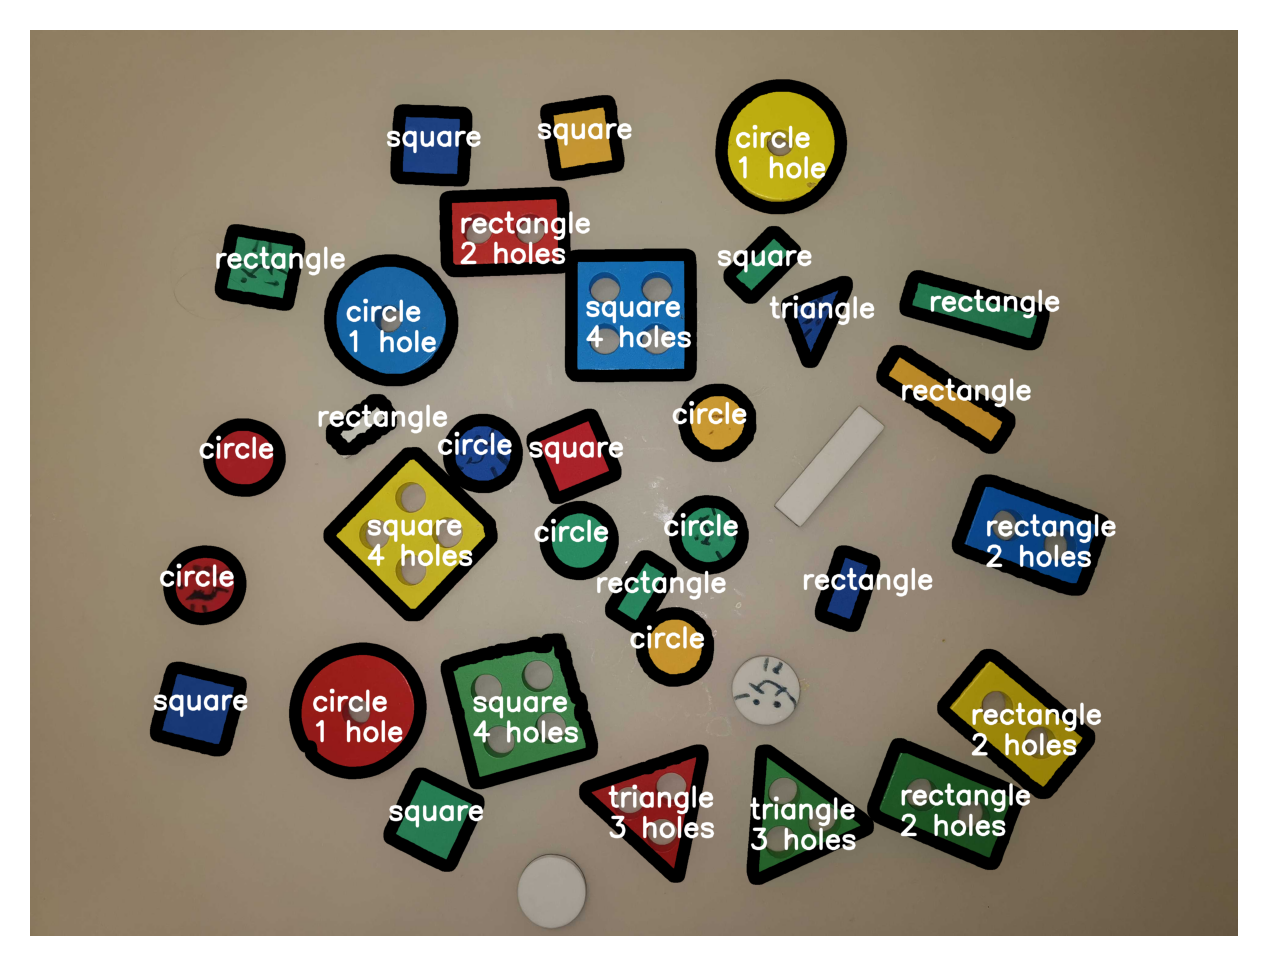

In [27]:
img_cnt_holes = img_cnt.copy()
for i in range(len(contours)):
    if hierarchy[0][i][-1] != 0:
        continue
    text = {0: "",
         1: "1 hole",
         2: "2 holes",
         3: "3 holes",
         4: "4 holes",}.get(n_holes[i], "too many holes")
    M = cv2.moments(contours[i])
    cX = int((M["m10"] / M["m00"]))
    cY = int((M["m01"] / M["m00"]))
    cv2.putText(img_cnt_holes, text, (cX-150, cY+100), cv2.FONT_HERSHEY_SIMPLEX,
        3, (255, 255, 255), 10)
    
plt.figure(dpi=300)    
plt.imshow(img_cnt_holes)
plt.axis("off")

In [30]:
x,y,w,h

(984, 1390, 532, array([-1, -1, -1, 64], dtype=int32))

### bonus - why don't make every figure red?

In [31]:
HLS2.shape

(2976, 3968, 3)

In [32]:
mask_int

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=uint8)

(-0.5, 3967.5, 2975.5, -0.5)

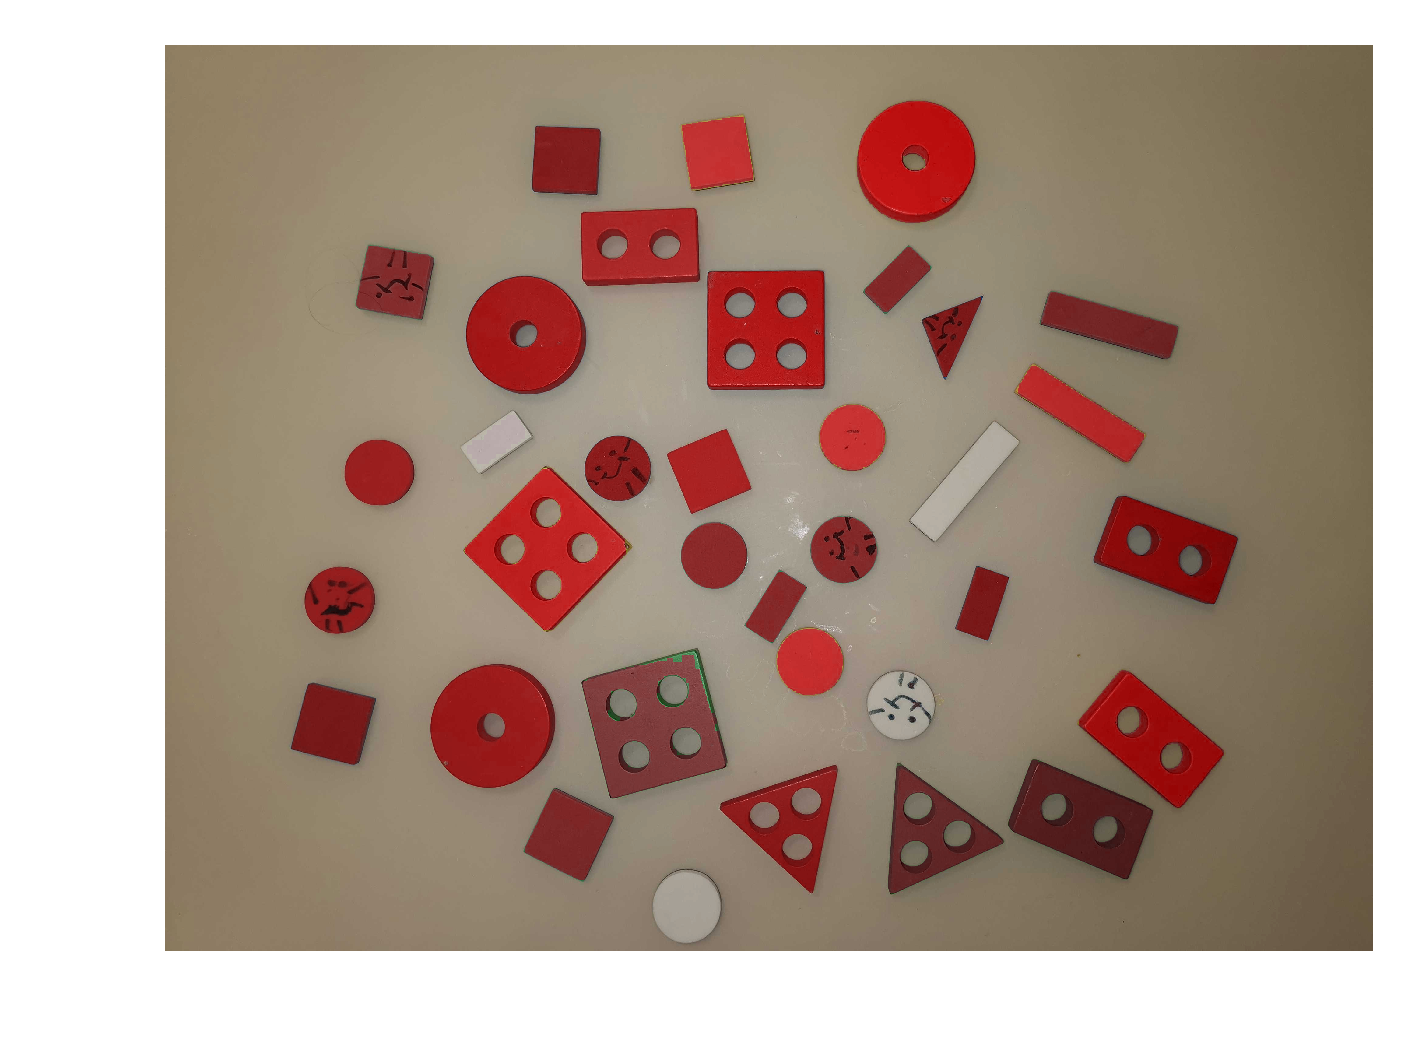

In [29]:
HLS2 = HLS.copy()
HLS2[mask_int == 0,0] = 0
img2 = cv2.cvtColor(HLS2, cv2.COLOR_HLS2RGB)
plt.figure(dpi=300)    
plt.imshow(img2)
plt.axis("off")